In [1]:
from dataloader import NetCDFSR, xr_standardize_field
import xarray as xr
import numpy as np
import glob
import torch

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from models import Generator, Discriminator

%load_ext autoreload
%autoreload 2

In [2]:
dataroot = "../data/era_interim/*.nc"
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

target = '10UV_GDS4_SFC'
uncropped = xr.open_mfdataset(glob.glob(dataroot), combine='by_coords')
uncropped[target] = xr.ufuncs.hypot(uncropped['10U_GDS4_SFC'], uncropped['10V_GDS4_SFC'])
xarr = uncropped[target][:30, ...]
xarr = xr_standardize_field(xarr)

In [3]:
assert np.abs(xr_standardize_field(xarr).mean()) < 10E-5
assert np.abs(xr_standardize_field(xarr).std() - 1.0) < 10E-5

In [4]:
midx = uncropped['10UV_GDS4_SFC'].values.shape[2] // 2
midy = uncropped['10UV_GDS4_SFC'].values.shape[1] // 2
assert midx >= 2*midy

In [5]:
fine = uncropped['10UV_GDS4_SFC'][:, :, midx-midy:midx+midy]

In [6]:
sx, sy = 4, 4
coarse = fine.coarsen(g4_lon_2=sx).mean().coarsen(g4_lat_1=sy).mean()

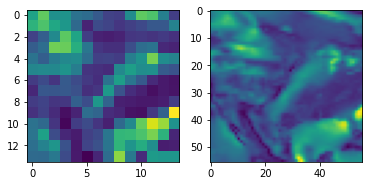

In [7]:
fig,ax = plt.subplots(1, 2)
ax[0].imshow(coarse[0, ...])
ax[1].imshow(fine[0, ...])

In [8]:
# PCA
ncomp = 800
fine_pca = np.array(fine).reshape(fine.shape[0], fine.shape[1]*fine.shape[2])
pca = PCA(n_components=ncomp)
pca.fit(fine_pca)
fine_sp_basis = pca.components_.reshape(ncomp, fine.shape[1]*fine.shape[2])

In [9]:
fine_t = torch.from_numpy(np.array(fine))
coarse_t = torch.from_numpy(np.array(coarse))
pcas_t = torch.from_numpy(fine_sp_basis)

In [10]:
dataset = NetCDFSR(
    fine_t,
    coarse_t,
    pcas_t,
    device=device
)

dataloader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=64,
    shuffle=True
)

In [11]:
real_batch, real_cbatch, pcas = next(iter(dataloader))
fixed = {"coarse": real_cbatch[:1, ...], "fine": real_batch[:1, ...]}

In [12]:
discriminator = Discriminator(7, 14, 1).to(device)
generator = Generator(14, 56, 1).to(device)
lr = 0.00025

In [13]:
G_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(.9, .99))
D_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(.9, .99))

# Set up trainer
from training import Trainer
trainer = Trainer(generator, discriminator, G_optimizer, D_optimizer,
                  use_cuda=torch.cuda.is_available(), print_every=50, device=device)

# Train model for 200 epochs
trainer.train(
    dataloader,
    epochs=600,
    fixed=fixed,
    save_training_gif=True
)



Epoch 1
Iteration 1
D: 8.583138465881348
GP: 8.534990310668945
Gradient norm: 0.07630520313978195
cuda memory: 661693952
Iteration 51
D: -0.20823872089385986
GP: 0.4890928268432617
Gradient norm: 0.8741507530212402
cuda memory: 663470592
G: 5.2880449295043945
Content loss: 3.2046589851379395
EOF:  2.083684206008911
Iteration 101
D: -0.25958251953125
GP: 0.5017412900924683
Gradient norm: 0.8783247470855713
cuda memory: 663470592
G: 3.5101094245910645
Content loss: 1.5502400398254395
EOF:  1.959969162940979

Epoch 2
Iteration 1
D: -0.18244868516921997
GP: 0.739608883857727
Gradient norm: 0.818406343460083
cuda memory: 663470592
G: 3.5210976600646973
Content loss: 1.5149345397949219
EOF:  2.006289005279541
Iteration 51
D: -0.8410290479660034
GP: 0.12374380230903625
Gradient norm: 0.9826269149780273
cuda memory: 663470592
G: 3.0334322452545166
Content loss: 1.179656744003296
EOF:  1.853890061378479
Iteration 101
D: -0.8390819430351257
GP: 0.13419793546199799
Gradient norm: 0.9945270419120

KeyboardInterrupt: 

In [ ]:
torch.cuda.empty_cache()